In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

### Variables
Here I will add in constants used and variables for use later related to time dilation effects

In [2]:
# Planet names (in order from closest to sun to farthest from sun)

Planets = ['Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune']

In [3]:
# Constants (SI) (indexed by planet's distance to the sun (closest to farthest))

# Masses of planets

M = [0.66e31, 9.74e31, 11.94e31, 1.284e31, 3796e31, 1136e31, 173.6e31, 204e31] # Scaled by 2e7

M_Sun = 3.978e35 # Scaled by 2e5

# Radii of planets

R = [2.4395e6, 6.052e6, 6.378e6, 3.396e6, 7.1492e7, 6.0268e7, 2.5559e7, 2.4764e7]

R_Sun = 6.96e8

# Radii of planetary orbits from sun

r = [57.9e9, 108.2e9, 149.6e9, 228e9, 778.5e9, 1432e9, 2867e9, 4515e9]

# Fundamental constants

G = 6.67430e-11

c = 2.99792458e8

In [4]:
# Important Values (Calculated)

# Schwarzschild radii

R_S = []

for i in range(len(M)):
    R_S.append((2*G*M[i])/(c**2))

R_S_Sun = (2*G*M_Sun)/(c**2)

# Planetary time dilation factors

gamma_P = []

for i in range(len(R_S)):
    gamma_P.append((1-(R_S[i]/R[i]))**(1/2))

# Sun time dilation factors

gamma_S = []

for i in range(len(r)):
    gamma_S.append((1-(R_S_Sun/r[i]))**(1/2))

In [5]:
# Compare relative time dilation from planets versus the sun

for i in range(len(gamma_P)):
    print(f"({Planets[i]}) Planetary: {gamma_P[i]} | Solar: {gamma_S[i]}")

(Mercury) Planetary: 0.9979888504497216 | Solar: 0.9948847989566293
(Venus) Planetary: 0.987976160264718 | Solar: 0.9972660163125732
(Earth) Planetary: 0.9859997777582559 | Solar: 0.9980233629268339
(Mars) Planetary: 0.9971882762610067 | Solar: 0.998703489989205
(Jupiter) Planetary: 0.4597701211158058 | Solar: 0.9996204640642193
(Saturn) Planetary: 0.8485555511211162 | Solar: 0.9997936849632081
(Uranus) Planetary: 0.9482199837310594 | Solar: 0.9998969557458743
(Neptune) Planetary: 0.9368298037393283 | Solar: 0.999934568699792


In [6]:
# Distance from home coloney (Earth)

# Radius from planet to Earth based off of relative sizes of orbits 

r_E = []

for i in range(len(r)):
        r_E.append(abs(r[i]-r[2]))

# For normalization purposes, I would like the minimum nonzero distance to Earth and to find this, I remove the Earth entry from the above list and look at the resulting minimum

r_E_nz = [] # Nonzero distances to Earth

for i in range(len(r_E)):
        if r_E[i] == 0:
                continue
        else:
                r_E_nz.append(r_E[i])

N = 0.5*min(r_E_nz) # Shortest distance to Earth (based off of orbital radius)


In [291]:
# Model Parameters (temporarily borrowed from the book)

# IS-LM Model parameters (fixed)

alpha = 0.2
beta = 0.8
T = 0.25
G = 20
m0_f = 2
u_f = 1.525
v_f = 0.2
i_f = 0.2
c_f = 0.75
k_f = 0.25

# IS-LM Model parameters (random)

alpha = 0.2
beta = 0.8
T = 0.25
G = 20
m0_r = 4 * np.random.rand(1,8)[0]
u_r = 3 * np.random.rand(1,8)[0]
v_r = 3 * np.random.rand(1,8)[0]
i_r = 3 * np.random.rand(1,8)[0]
c_r = 1 * np.random.rand(1,8)[0]
k_r = 3 * np.random.rand(1,8)[0]

# Coupling parameters

l = 0.1
n = 0.1

In [292]:
# Calculate planetary consumer consumption-investment index

# For fixed parameters

C_f = []

for I in range(len(Planets)):
    C_f.append(c_f*(1-T) + (i_f - 1))

# For random parameters

C_r = []

for I in range(len(Planets)):
    C_r.append(c_r[I]*(1-T) + (i_r[I] - 1))


### Project System Model

In [157]:
# Set up system (fixed)

def dPdt(t, P):
    g0, r0, g1, r1, g2, r2, g3, r3, g4, r4, g5, r5, g6, r6, g7, r7 = P
    return[gamma_P[0]*alpha*(C_f[0]*g0 - u_f*r0 + (G + l*(gamma_P[2]/gamma_P[0])*(g2 - g0)*g0)), # Mercury equations
           gamma_P[0]*beta*(k_f*g0 - v_f*r0 - m0_f + n*r2),
           gamma_P[1]*alpha*(C_f[1]*g1 - u_f*r1 + (G + l*(gamma_P[2]/gamma_P[1])*(g2 - g1)*g1)), # Venus equations
           gamma_P[1]*beta*(k_f*g1 - v_f*r1 - m0_f + n*r2),
           gamma_P[2]*alpha*(C_f[2]*g2 - u_f*r2 + G), # Earth equations
           gamma_P[2]*beta*(k_f*g2 - v_f*r2 - m0_f),
           gamma_P[3]*alpha*(C_f[3]*g3 - u_f*r3 + (G + l*(gamma_P[2]/gamma_P[3])*(g2 - g3)*g3)), # Mars equations
           gamma_P[3]*beta*(k_f*g3 - v_f*r3 - m0_f + n*r2),
           gamma_P[4]*alpha*(C_f[4]*g4 - u_f*r4 + (G + l*(gamma_P[2]/gamma_P[4])*(g2 - g4)*g4)), #Jupiter equations
           gamma_P[4]*beta*(k_f*g4 - v_f*r4 - m0_f + n*r2),
           gamma_P[5]*alpha*(C_f[5]*g5 - u_f*r5 + (G + l*(gamma_P[2]/gamma_P[5])*(g2 - g5)*g5)), # Saturn equations
           gamma_P[5]*beta*(k_f*g5 - v_f*r5 - m0_f + n*r2),
           gamma_P[6]*alpha*(C_f[6]*g6 - u_f*r6 + (G + l*(gamma_P[2]/gamma_P[6])*(g2 - g6)*g6)), # Uranus equations 
           gamma_P[6]*beta*(k_f*g6 - v_f*r6 - m0_f + n*r2),
           gamma_P[7]*alpha*(C_f[7]*g7 - u_f*r7 + (G + l*(gamma_P[2]/gamma_P[7])*(g2 - g7)*g7)), # Neptune equations
           gamma_P[7]*beta*(k_f*g7 - v_f*r7 - m0_f + n*r2)]

In [295]:
# Set up system (random)

def dPdt(t, P):
    g0, r0, g1, r1, g2, r2, g3, r3, g4, r4, g5, r5, g6, r6, g7, r7 = P
    return[gamma_P[0]*alpha*(C_r[0]*g0 - u_r[0]*r0 + (G + l*(gamma_P[2]/gamma_P[0])*(g2 - g0)*g0)), # Mercury equations
           gamma_P[0]*beta*(k_r[0]*g0 - v_r[0]*r0 - m0_r[0] + n*r2),
           gamma_P[1]*alpha*(C_r[1]*g1 - u_r[1]*r1 + (G + l*(gamma_P[2]/gamma_P[1])*(g2 - g1)*g1)), # Venus equations
           gamma_P[1]*beta*(k_r[1]*g1 - v_r[1]*r1 - m0_r[1] + n*r2),
           gamma_P[2]*alpha*(C_r[2]*g2 - u_r[2]*r2 + G), # Earth equations
           gamma_P[2]*beta*(k_r[2]*g2 - v_r[2]*r2 - m0_r[2]),
           gamma_P[3]*alpha*(C_r[3]*g3 - u_r[3]*r3 + (G + l*(gamma_P[2]/gamma_P[3])*(g2 - g3)*g3)), # Mars equations
           gamma_P[3]*beta*(k_r[3]*g3 - v_r[3]*r3 - m0_r[3] + n*r2),
           gamma_P[4]*alpha*(C_r[4]*g4 - u_r[4]*r4 + (G + l*(gamma_P[2]/gamma_P[4])*(g2 - g4)*g4)), #Jupiter equations
           gamma_P[4]*beta*(k_r[4]*g4 - v_r[4]*r4 - m0_r[4] + n*r2),
           gamma_P[5]*alpha*(C_r[5]*g5 - u_r[5]*r5 + (G + l*(gamma_P[2]/gamma_P[5])*(g2 - g5)*g5)), # Saturn equations
           gamma_P[5]*beta*(k_r[5]*g5 - v_r[5]*r5 - m0_r[5] + n*r2),
           gamma_P[6]*alpha*(C_r[6]*g6 - u_r[6]*r6 + (G + l*(gamma_P[2]/gamma_P[6])*(g2 - g6)*g6)), # Uranus equations 
           gamma_P[6]*beta*(k_r[6]*g6 - v_r[6]*r6 - m0_r[6] + n*r2),
           gamma_P[7]*alpha*(C_r[7]*g7 - u_r[7]*r7 + (G + l*(gamma_P[2]/gamma_P[7])*(g2 - g7)*g7)), # Neptune equations
           gamma_P[7]*beta*(k_r[7]*g7 - v_r[7]*r7 - m0_r[7] + n*r2)]

In [296]:
# Set initial conditions

ic = 20 * np.random.rand(2,8)

g0_0 = ic[0][0] # Mercury initial GDP 
r0_0 = ic[1][0] # Mercury initial interest rate
g1_0 = ic[0][1] # Venus initial GDP
r1_0 = ic[1][1] # Venus initial interest rate
g2_0 = ic[0][2] # Earth initial GDP
r2_0 = ic[1][2] # Earth initial interest rate
g3_0 = ic[0][3] # Mars initial GDP
r3_0 = ic[1][3] # Mars initial interest rate
g4_0 = ic[0][4] # Jupiter initial GDP
r4_0 = ic[1][4] # Jupiter initial interest rate
g5_0 = ic[0][5] # Saturn initial GDP
r5_0 = ic[1][5] # Saturn initial interest rate
g6_0 = ic[0][6] # Uranus initial GDP
r6_0 = ic[1][6] # Uranus initial interest rate
g7_0 = ic[0][7] # Neptune initial GDP
r7_0 = ic[1][7] # Neptune initial interest rate
P0 = (g0_0, r0_0, g1_0, r1_0, g2_0, r2_0, g3_0, r3_0, g4_0, r4_0, g5_0, r5_0, g6_0, r6_0, g7_0, r7_0) # set initial condition for system
t = np.linspace(0, 50, 10000) # variable interval

In [297]:
# Solve

sys_solution = odeint(dPdt, y0 = P0, t=t, tfirst=True)
g0_sol = sys_solution.T[0] # get g0 solution
r0_sol = sys_solution.T[1] # get r0 solution
g1_sol = sys_solution.T[2] # get g1 solution
r1_sol = sys_solution.T[3] # get r1 solution
g2_sol = sys_solution.T[4] # get g2 solution
r2_sol = sys_solution.T[5] # get r2 solution
g3_sol = sys_solution.T[6] # get g3 solution
r3_sol = sys_solution.T[7] # get r3 solution
g4_sol = sys_solution.T[8] # get g4 solution
r4_sol = sys_solution.T[9] # get r4 solution
g5_sol = sys_solution.T[10] # get g4 solution
r5_sol = sys_solution.T[11] # get r4 solution
g6_sol = sys_solution.T[12] # get g4 solution
r6_sol = sys_solution.T[13] # get r4 solution
g7_sol = sys_solution.T[14] # get g4 solution
r7_sol = sys_solution.T[15] # get r4 solution


### Analysis
Plots 

In [298]:
# Analyse stability of different economies

# Jacobian variables (fixed)

Delta_f = []
Trace_f = []

for i in range(len(Planets)):
    Delta_f.append(alpha*beta*(u_f*k_f - v_f*C_f[i]))
    Trace_f.append(alpha*C_f[i]-beta*v_f)

# Jacobian variables (random)

Delta_r = []
Trace_r = []

for i in range(len(Planets)):
    Delta_r.append(alpha*beta*(u_r[i]*k_r[i] - v_r[i]*C_r[i]))
    Trace_r.append(alpha*C_r[i]-beta*v_r[i])

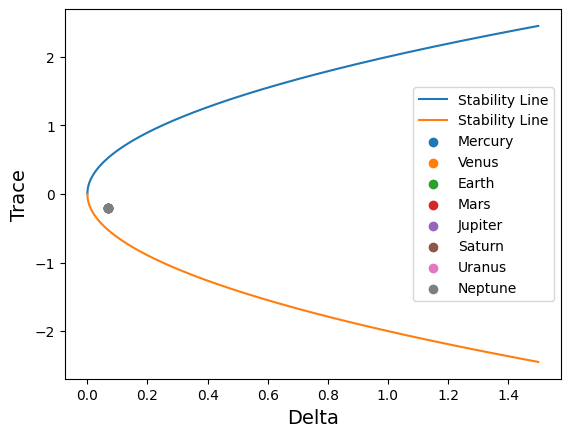

In [299]:
# Make a plot for the stability of the economies (fixed)

x = np.linspace(0, 1.5, 1000)

plt.plot(x, 2*(x)**(1/2))
plt.plot(x, -2*(x)**(1/2))
plt.scatter(Delta_f[0], Trace_f[0])
plt.scatter(Delta_f[1], Trace_f[1])
plt.scatter(Delta_f[2], Trace_f[2])
plt.scatter(Delta_f[3], Trace_f[3])
plt.scatter(Delta_f[4], Trace_f[4])
plt.scatter(Delta_f[5], Trace_f[5])
plt.scatter(Delta_f[6], Trace_f[6])
plt.scatter(Delta_f[7], Trace_f[7])
plt.ylabel('Trace', fontsize = 14)
plt.xlabel('Delta', fontsize = 14)
plt.legend(['Stability Line', 'Stability Line', 'Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune'])
plt.show()

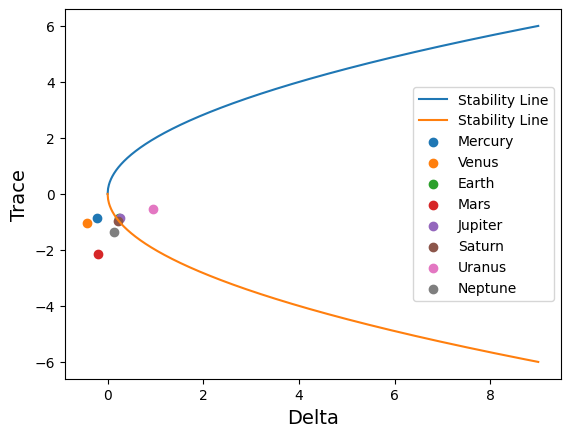

In [300]:
# Make a plot for the stability of the economies (random)

x = np.linspace(0, 9, 1000)

plt.plot(x, 2*(x)**(1/2))
plt.plot(x, -2*(x)**(1/2))
plt.scatter(Delta_r[0], Trace_r[0])
plt.scatter(Delta_r[1], Trace_r[1])
plt.scatter(Delta_r[2], Trace_r[2])
plt.scatter(Delta_r[3], Trace_r[3])
plt.scatter(Delta_r[4], Trace_r[4])
plt.scatter(Delta_r[5], Trace_r[5])
plt.scatter(Delta_r[6], Trace_r[6])
plt.scatter(Delta_r[7], Trace_r[7])
plt.ylabel('Trace', fontsize = 14)
plt.xlabel('Delta', fontsize = 14)
plt.legend(['Stability Line', 'Stability Line', 'Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune'])
plt.show()

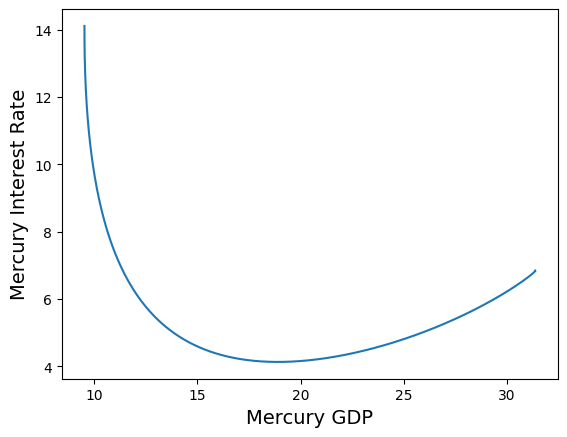

In [301]:
# Mercury plot

plt.plot(g0_sol, r0_sol)
plt.ylabel('Mercury Interest Rate', fontsize = 14)
plt.xlabel('Mercury GDP', fontsize = 14)
plt.show()

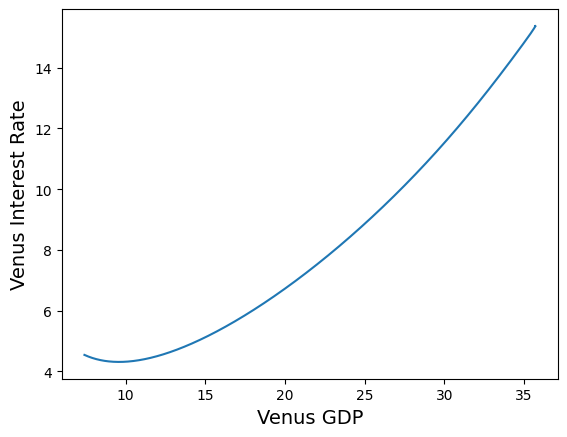

In [302]:
# Venus plot

plt.plot(g1_sol, r1_sol)
plt.ylabel('Venus Interest Rate', fontsize = 14)
plt.xlabel('Venus GDP', fontsize = 14)
plt.show()

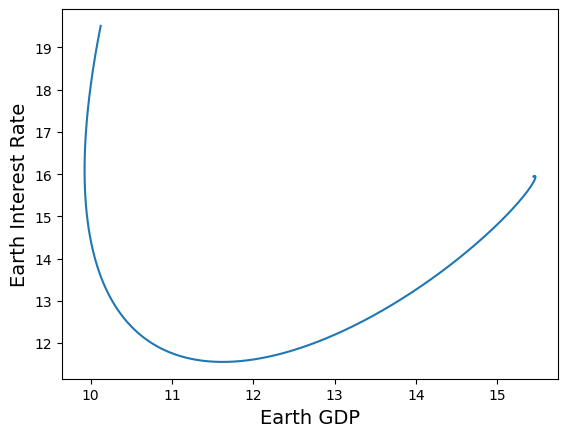

In [303]:
# Earth plot

plt.plot(g2_sol, r2_sol)
plt.ylabel('Earth Interest Rate', fontsize = 14)
plt.xlabel('Earth GDP', fontsize = 14)
plt.show()

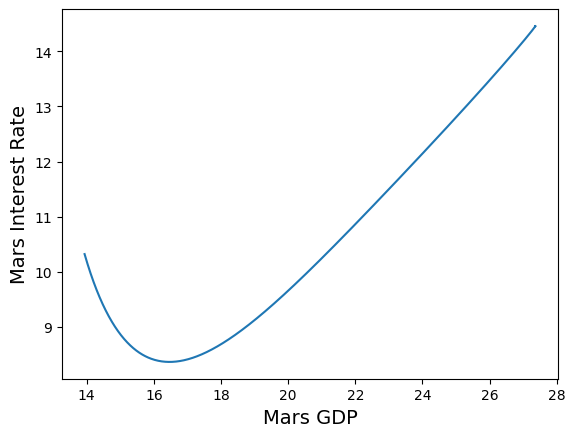

In [304]:
# Mars plot

plt.plot(g3_sol, r3_sol)
plt.ylabel('Mars Interest Rate', fontsize = 14)
plt.xlabel('Mars GDP', fontsize = 14)
plt.show()

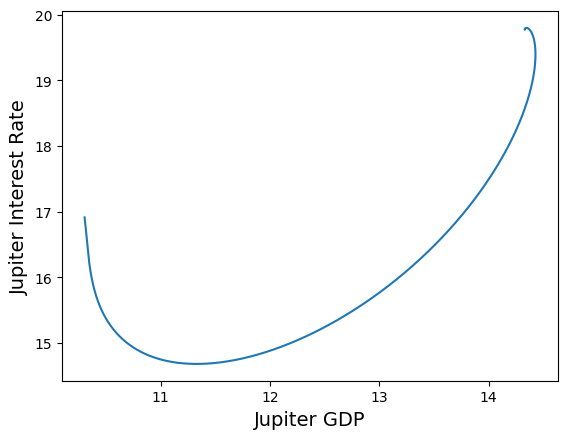

In [305]:
# Jupiter plot

plt.plot(g4_sol, r4_sol)
plt.ylabel('Jupiter Interest Rate', fontsize = 14)
plt.xlabel('Jupiter GDP', fontsize = 14)
plt.show()

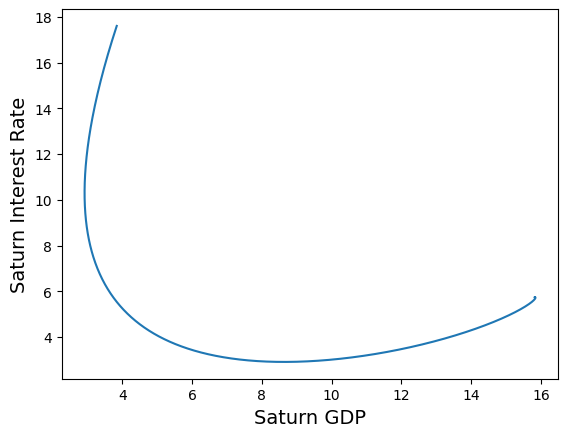

In [306]:
# Saturn plot

plt.plot(g5_sol, r5_sol)
plt.ylabel('Saturn Interest Rate', fontsize = 14)
plt.xlabel('Saturn GDP', fontsize = 14)
plt.show()

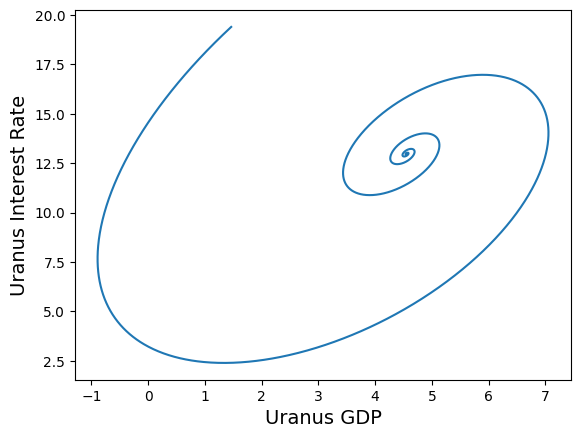

In [307]:
# Uranus plot

plt.plot(g6_sol, r6_sol)
plt.ylabel('Uranus Interest Rate', fontsize = 14)
plt.xlabel('Uranus GDP', fontsize = 14)
plt.show()

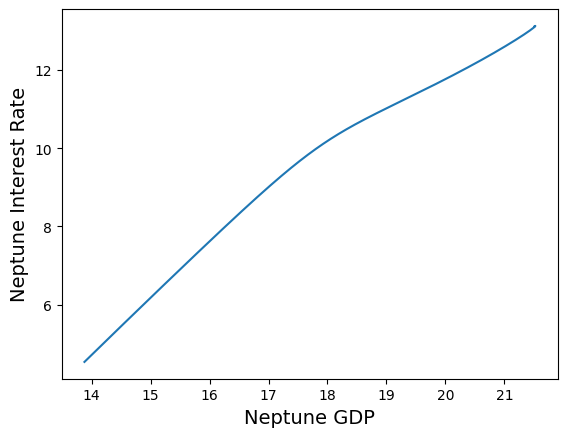

In [308]:
# Neptune plot

plt.plot(g7_sol, r7_sol)
plt.ylabel('Neptune Interest Rate', fontsize = 14)
plt.xlabel('Neptune GDP', fontsize = 14)
plt.show()

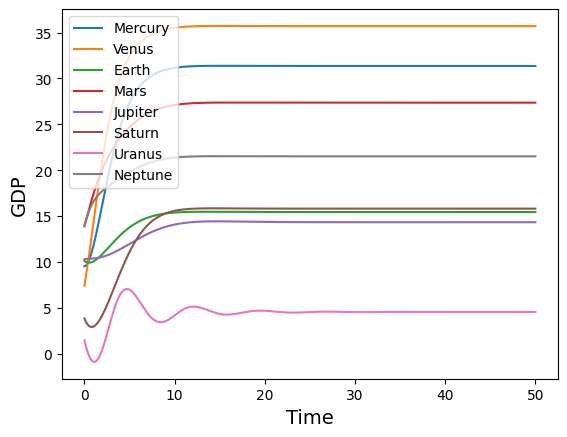

In [309]:
# Relative GDP performance plots

plt.plot(t, g0_sol)
plt.plot(t, g1_sol)
plt.plot(t, g2_sol)
plt.plot(t, g3_sol)
plt.plot(t, g4_sol)
plt.plot(t, g5_sol)
plt.plot(t, g6_sol)
plt.plot(t, g7_sol)
plt.ylabel('GDP', fontsize = 14)
plt.xlabel('Time', fontsize = 14)
plt.legend(['Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune'])
plt.show()

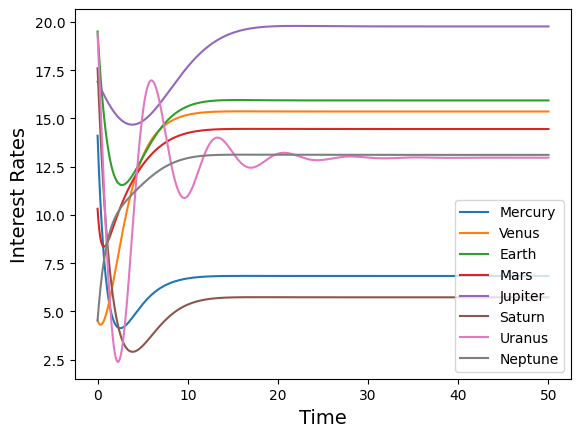

In [310]:
# Relative interest rate plots

plt.plot(t, r0_sol)
plt.plot(t, r1_sol)
plt.plot(t, r2_sol)
plt.plot(t, r3_sol)
plt.plot(t, r4_sol)
plt.plot(t, r5_sol)
plt.plot(t, r6_sol)
plt.plot(t, r7_sol)
plt.ylabel('Interest Rates', fontsize = 14)
plt.xlabel('Time', fontsize = 14)
plt.legend(['Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune'])
plt.show()